# Introduction <a id="intro"></a>

For this project, I was interested in finding out how different features of Les Paul electric guitars affect their price and sales rank on the Thomann website.

Thomann stocks a wide range of musical equipment and was the perfect source to get structured information on Les Paul guitars. I used the web-scraping framework *Scrapy* to get the product info and create the dataset for this project. I was interestested in using these data to better understand:

1. [How does guitar price affect the sales rank?](#price_rank)
2. [How does the choice of wood for different parts affect the sales rank?](#wood_rank)
3. [Which features of a Les Paul guitar are most important in determining the price?](#features_price)

Note: these analyses can be applied to combinations of electric guitar categories, but for the first foray into these data, it would be best to focus on a singular guitar type.

# Processing the raw data

In [49]:
# necessary imports
import ast
import pylab as pl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
sns.set_palette('Set2')

# if this is your first time running this notebook
# leave skip_processing as False, but if you are
# coming back to look at the analysis, change
# its value to True and skip ahead to the questions
skip_processing = False

if skip_processing:
    df = pd.read_csv('processed_lp_product_data.csv')
else:
    raw_df = pd.read_csv('raw_lp_product_data.csv')
    print(raw_df.columns)

Index(['further_info_table', 'info_list', 'link', 'name', 'num_reviews',
       'overall_rating', 'price', 'rank_in_group', 'rank_overall',
       'sales_info'],
      dtype='object')


Looking at the dataframe, you can see that we have a number of variables about each guitar:

1. further_info_table: a dictionary of attributes for the guitar. The keys represent the guitar color, number of frets, the scale length, pickup configuration, the woods used for different parts of the guitar, whether there is a whammy bar or tremolo system, and if it includes a case or bag.
2. info_list: the block of text describing the product. The format varies from a list of attributes to an unstructured description of the guitar
3. A link to the item page
4. The brand and model of the guitar
5. The overall rating
6. The sales price
7. The sales rank in the group of similar products
8. The sales rank among all products on the website
9. The sales info: dictionary of sales data including item number, sales unit, and the date the guitar was first available on the website

In [50]:
# Inspect values for each col in cols for a given row
# Feel free to change the item_idx value below to check other item info
item_idx = 0
descriptions = ['further_info_table key-value pairs for the first item', 'info_list text for the first item',
                'sales_info for the first item']
cols = ['further_info_table', 'info_list', 'sales_info']

for description, col in zip(descriptions, cols):
    if item_idx < raw_df.shape[0]:
        print(description)
        print(raw_df[col][item_idx])
        print('\n')
    else:
        print("There aren't that many items in the dataset")

further_info_table key-value pairs for the first item
{'Colour': 'Amber', 'Body': 'Mahogany', 'Top': 'Maple', 'Neck': 'Mahogany', 'Fretboard': 'Rosewood', 'Frets': '22', 'Scale': '628 mm', 'Pickups': 'HH', 'Tremolo': 'None', 'Incl. Case': 'Yes', 'Incl. Gigbag': 'No'}


info_list text for the first item
Slash signature model,Body: Mahogany,Top: AAA flamed maple,Neck: Mahogany,Fretboard: Rosewood,Neck profile: Thick,22 Frets,Scale: 628 mm,Nut width: 43 mm,Tektoid nut,Pickup: 2 Slash Bucker (Zebra) humbuckers,ABR bridge,Aluminium stop bar,Colour: Appetite Amber,Includes case, accessory kit and Slash pick set,Made in USA


sales_info for the first item
{'item number': '482160', 'sales unit': '1 piece', 'available since': 'September 2020'}




In [51]:
# Let's have a look at the data for a single guitar
print(raw_df.iloc[0, :])

further_info_table    {'Colour': 'Amber', 'Body': 'Mahogany', 'Top':...
info_list             Slash signature model,Body: Mahogany,Top: AAA ...
link                  https://www.thomann.de/ie/gibson_les_paul_slas...
name                                  Gibson Les Paul Slash Standard AA
num_reviews                                                           4
overall_rating                                                      4.5
price                                                            €2,890
rank_in_group                                                        10
rank_overall                                                       1242
sales_info            {'item number': '482160', 'sales unit': '1 pie...
Name: 0, dtype: object


A quick look at the output of the previous cell shows that we will need to: <a id="helpers"></a>
1. Extract the date the guitar was first available into a separate column
2. Reformat the `price` column so Pandas can interpret it as an integer
3. Extract the dictionary from `further_info_table` and create columns based on the keys

In [52]:
# 1. Extract date and calculate months available
def _get_months_available(info_col):
    """
    Calculate the months a guitar was available for
    
    info_col: Pandas Series
        contains a dictionary in string format
        
    returns a list of float values for the time the guitar was on the website
    """
    months = []
    for data in info_col:
        
        # The ast library can easily extract dictionaries displayed as strings
        # I tried using the json library but kept running into errors
        d = ast.literal_eval(data)
        
        if 'available since' in d.keys():
            date = d['available since']
            # get date as datetime object
            since = datetime.strptime(date, "%B %Y")
            now = datetime.now()
            # calculate the time difference
            diff = (now - since).days / 30
            months.append(diff)
        else:
            # if 'available since' is not present, append NaN
            months.append(np.nan)
    return months

# 2. Format price column
fix_price = lambda price: int(price[1:].replace(',', ''))

# 3. Extract dictionaries of info from further_info_table column
def extract_further_info(data):
    for i, row in data.iterrows():
        further_info = ast.literal_eval(row["further_info_table"])
        for info in further_info:
            for k, v in further_info.items():
                data.loc[i, k] = v


In [53]:
# apply functions
raw_df['months_available'] = _get_months_available(raw_df['sales_info'])
raw_df['price'] = raw_df['price'].apply(fix_price)
extract_further_info(raw_df)

print(raw_df.iloc[0, :])

further_info_table    {'Colour': 'Amber', 'Body': 'Mahogany', 'Top':...
info_list             Slash signature model,Body: Mahogany,Top: AAA ...
link                  https://www.thomann.de/ie/gibson_les_paul_slas...
name                                  Gibson Les Paul Slash Standard AA
num_reviews                                                           4
overall_rating                                                      4.5
price                                                              2890
rank_in_group                                                        10
rank_overall                                                       1242
sales_info            {'item number': '482160', 'sales unit': '1 pie...
months_available                                                6.73333
Colour                                                            Amber
Body                                                           Mahogany
Top                                                             

Great! We now have the `further_info_table` data as separate columns!

The `Scale` column looks like a string containing the scale length in mm, so we'll need to tidy that up. Let's also remove any leading or trailing whitespace in each string column, and ensure all numeric columns are indeed numeric.

In [54]:
# change scale and frets columns to integers
raw_df['Scale'] = raw_df['Scale'].str.replace(' mm', '').astype(float)
raw_df['Frets'] = raw_df['Frets'].astype(float)

Finally, let's create dummy columns for each categorical variable of interest

In [55]:
# remove leading and trailing whitespace from string columns
# make string column lower case as well
def strip_whitespace(data):
    string_cols = data.select_dtypes(include=['object']).columns
    for col in string_cols:
        data[col] = data[col].str.strip().str.lower()
    return data

raw_df = strip_whitespace(raw_df)

# make dummy columns
dummy_cols = ['Colour', 'Body', 'Top', 'Neck', 'Fretboard', 'Pickups',
              'Tremolo', 'Incl. Case']
for col in dummy_cols:
    # create a column for any NaN values in col
    raw_df = pd.concat([raw_df, pd.get_dummies(raw_df[col], dummy_na=True,
                                               prefix=col)], axis=1)

Now let's check for NaN values in our data

In [56]:
for col in raw_df.columns:
    nan = raw_df[col].isna().sum()
    percent_nan = round(nan / raw_df.shape[0], 2)
    if nan > 0:
        print(f"{col}\t{percent_nan}")

info_list	0.17
num_reviews	0.53
overall_rating	0.53
months_available	0.19
Colour	0.05
Body	0.04
Top	0.07
Neck	0.03
Fretboard	0.03
Frets	0.03
Scale	0.03
Pickups	0.06
Tremolo	0.03
Incl. Case	0.03
Incl. Gigbag	0.05
Artist	0.99
Style	0.99
Incl. Bag	0.98
Shape	0.98
Soundboard	0.99
Active Pickups	0.99
Model	0.98
Pickup System	0.98


Hmmm, there are a good few columns that contain many NaN values.

Those columns that are more than 90% NaN values should be dropped. `info_list` can be dropped as it's just lots of string info. `num_reviews` should be 0 rather than NaN, because the element may not have been present on the page during scraping.
Many of these guitars also haven't been rated, so rather than drop those columns, let's re-encode this as a categorical variable.

Many rows with NaN values have also been re-encoded to dummy columns, so we can safely drop these columns too.

Let's also check how many rows we would remove, if we then dropped all rows with NaN values

In [57]:
# reuse code above and extend to remove columns
# with more than 90% NaN
for col in raw_df.columns:
    nan = raw_df[col].isna().sum()
    percent_nan = round(nan / raw_df.shape[0], 2)
    if percent_nan > 0.9:
        raw_df.drop(columns=[col], inplace=True)
        
# fill num_reviews with 0 if NaN
raw_df['num_reviews'].fillna(0, inplace=True)

# encode ratings column as categorical variable
raw_df['overall_rating'] = np.where(raw_df['overall_rating'].isna(), 0, 1)

# drop dummy cols and cols with complex string info
drop_cols = ['Colour', 'Body', 'Top', 'Neck', 'Fretboard', 'Pickups',
            'Tremolo', 'Incl. Case', 'Incl. Gigbag', 'info_list']
raw_df.drop(columns=drop_cols, inplace=True)

rows_before_drop = raw_df.shape[0]
rows_after = raw_df.dropna().shape[0]
print(f"{rows_before_drop} rows before dropping\n{rows_after} rows afterward")

553 rows before dropping
433 rows afterward


In [58]:
for col in raw_df.columns:
    nan = raw_df[col].isna().sum()
    percent_nan = round(nan / raw_df.shape[0], 2)
    if nan > 0:
        print(f"{col}\t{percent_nan}")

months_available	0.19
Frets	0.03
Scale	0.03


We seem to be losing about 20% of the rows and I suspect this is caused by NaN values for `months_available`, so let's ignore that column for further analysis, drop other rows with NaN values, and check how many rows are left.

In [59]:
raw_df.drop(columns=['months_available'], inplace=True)
raw_df.dropna(inplace=True)

rows_after = raw_df.shape[0]
print(f"{rows_before_drop} rows before dropping\n{rows_after} rows afterward")

553 rows before dropping
537 rows afterward


Excellent! We've now retained most of the data and can proceed to addressing the questions outlined at the start of this notebook.

I'll include a quick cell to save the dataframe in its current state, so you can quickly reload it instead of processing the raw data again.

In [60]:
raw_df.to_csv('processed_lp_product_data.csv', index=False)

# How does guitar price affect the sales rank? <a id="price_rank"></a>
[back to top](#intro)

The popularity of a guitar can be affected by a combination of product specifications, such as the tonewoods used in different parts of the guitar, number of frets, pickup configurations, etc. but a company like Thomann might be interested in finding out how the list price of a guitar affects its sales rank.

We have two reference points for the rank of each guitar: the rank within it's category and the rank on the website as a whole. Let's check the relationship between these variables and the price using correlation. We'll use Spearman correlation to quantify this relationship, as the relationship may be non-linear.

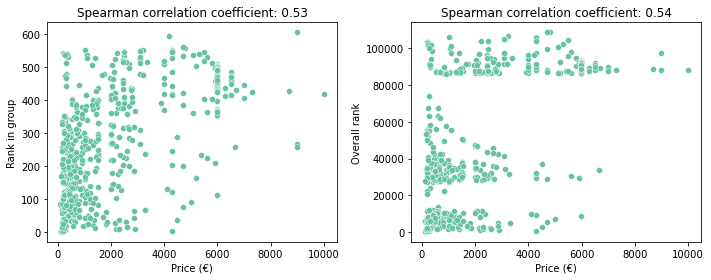

In [61]:
from scipy.stats import spearmanr

df = pd.read_csv('processed_lp_product_data.csv')

# creat figure
plt.figure(figsize=(10,4))
cols = ['rank_in_group', 'rank_overall']
labels = ['Rank in group', 'Overall rank']

# loop through the columns and labels for the y axes
for i, (rank, rank_label) in enumerate(zip(cols, labels), 1):
    # create scatterplots
    plt.subplot(1, 2, i)
    sns.scatterplot(x='price', y=rank, data=df)
    plt.ylabel(rank_label)
    plt.xlabel('Price (€)')
    
    #calculate the spearman correlation coefficient
    spearman_corr, pval = spearmanr(df['price'], df[rank])
    plt.title(f"Spearman correlation coefficient: {spearman_corr:.2f}")
    
plt.tight_layout()
plt.savefig('01_correlation.png')

A quick look at the scatterplot indicates that there isn't a correlation between `price` and `rank_in_group`, but the Spearman correlation coefficient determines that there's a moderate correlation, which may be more readily visualised using seaborn's `kdeplot`.

We see a similar calculation for the correlation coefficient between `price` and `rank_overall`, but the data appears to be split into 3 subgroups of high, medium, and low ranking guitars.

Higher priced guitars are more likely to be low rank, because **customers probably don't often buy guitars costing several thousand Euro!**

In [62]:
def map_ranks(val):
    """
    Map rank column to a category,
    (High, Medium, or Low).
    Apply this function to a Pandas Series
    
    return rank
    """
    if val < 20000:
        rank = 'High'
    elif val > 80000:
        rank = 'Low'
    else:
        rank = 'Medium'
    return rank

df['overall_rank_categories'] = df['rank_overall'].apply(map_ranks)
print('Mean prices')
print(df.groupby('overall_rank_categories', sort=False).agg({'price' : 'mean'}).astype(int))
print('\nMedian prices')
print(df.groupby('overall_rank_categories', sort=False).agg({'price' : 'median'}).astype(int))

Mean prices
                         price
overall_rank_categories       
High                      1004
Medium                    1071
Low                       3830

Median prices
                         price
overall_rank_categories       
High                       599
Medium                     632
Low                       3999


Indeed, the high-ranked guitars have an average selling price around €1000 and medium-ranked guitars are only slightly more expensive, while the low-ranked guitars have an average price €4000!

Checking the median prices of these ranks, follows a similar trend as the mean values, but the high and medium rank guitars are also about €400 cheaper than the mean. This makes sense because most people looking to buy guitars will typically spend few hundred Euro to get a mid-range instrument of good quality and playability.

Let's have a quick look at the kdeplots of these data to see if there's any more insight to be found.

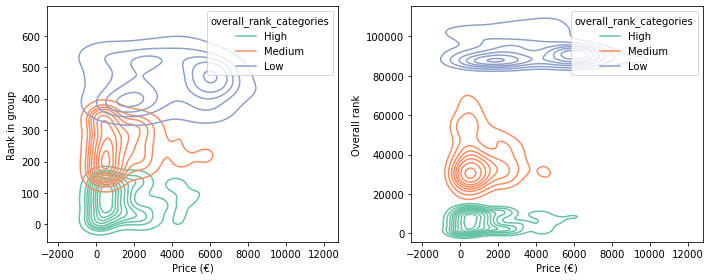

In [63]:
plt.figure(figsize=(10,4))

cols = ['rank_in_group', 'rank_overall']
labels = ['Rank in group', 'Overall rank']
for i, (rank, rank_label) in enumerate(zip(cols, labels), 1):
    # create kdeplots
    plt.subplot(1, 2, i)
    sns.kdeplot(x='price', y=rank, data=df, hue='overall_rank_categories')
    plt.ylabel(rank_label)
    plt.xlabel('Price (€)')
    
plt.tight_layout()
plt.savefig('02_kdeplots.png')

Interestingly, we can see that there are two subgroups of prices for the low-ranked guitars. These are clearly present in both rank variables.

Low-rank guitar subgroups have median prices around €2160 and €5938


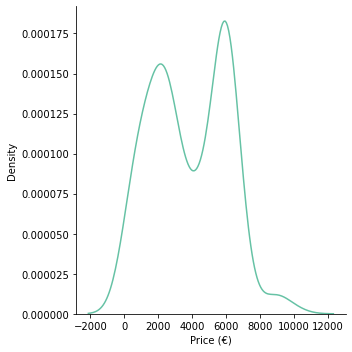

In [64]:
# get only data for Low ranked guitars
low = df.query("overall_rank_categories == 'Low'")

# the distplot class is deprected and due to be removed in future
# versions, so we should use displot instead.
# we can get the line data from the current axes
# and check the approximate values of the two peaks
sns.displot(low['price'], kind='kde')
ax = plt.gca()
plt.xlabel('Price (€)')

# get x and y coordinates of the kde line
line_data = ax.lines[0]
y = line_data.get_ydata()
x = line_data.get_xdata()

# use find_peaks from scipy to get peak locations
from scipy.signal import find_peaks
peak_idxs, _ = find_peaks(y)
peak_prices = [round(x[p]) for p in peak_idxs]
print(f"Low-rank guitar subgroups have median prices around €{peak_prices[0]} and €{peak_prices[1]}")

# How does the choice of wood affect the sales rank?<a id="wood_rank"></a>
[back to top](#intro)

The tonewoods used to make up an electric guitar are the subject of great discussion, as these woods give guitars a characteristic sound, or so they say. Maple gives the guitar good clarity when notes are played, while mahogany imparts a more mellow, bassy quality to the sound profile. We have access to the woods used in the construction of the body, neck, fretboard, and top of each guitar.

Though we converted these columns into dummy variables for later analysis, we can read in the raw data and select only these variables. We will only look at `rank_in_group` as wood use in different guitar parts varies widely from one type to the next.

To prep the data, rerun the functions from a previous ([cell](#helpers)) before running the cell below.

In [65]:
# read in raw data
raw_df = pd.read_csv('raw_lp_product_data.csv')

# define columns of interest
columns = ['rank_in_group', 'Body', 'Top', 'Fretboard', 'Neck']

# format price and extract wood data
extract_further_info(raw_df)
woods = raw_df[columns]

# normalize group rank to range (0, 1)
max_rank_val = woods['rank_in_group'].max()
woods['rank_in_group'] = woods['rank_in_group'] / max_rank_val

<ipython-input-65-42e3242b4660>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  woods['rank_in_group'] = woods['rank_in_group'] / max_rank_val


                         count  mean  median
Body                                        
Alder                       15  0.48    0.46
Ash                          2  0.29    0.29
Basswood                    40  0.40    0.40
Chambered Spanish Cedar      2  0.62    0.62
Mahogany                   431  0.47    0.47
Nato                         7  0.38    0.39
Okoume                      15  0.34    0.27
Poplar                      11  0.36    0.36
Sapele                       1  0.41    0.41
Silverleaf Maple             2  0.46    0.46
Solid Wood                   3  0.03    0.02
Spruce                       2  0.39    0.39


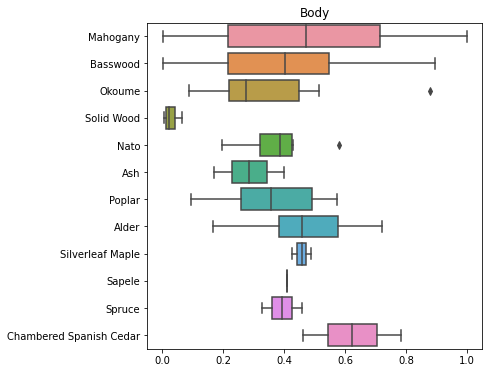

In [67]:
def plot_wood(wood_col):
    """
    Make boxplot and add counts of each wood in wood_col
    to the figure (using pylab)
    
    """

    plt.figure(figsize=(6,6))
    
    # make boxplot
    ax = sns.boxplot(y=wood_col, x='rank_in_group', data=woods, orient='h')
    
    # tidy up labels and add title
    ax.set_title(wood_col)
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.savefig(f'03_{wood_col}.png', bbox_inches='tight')
    
    # get count, mean, and median info
    # I had intended to plot the two side-by-side but it's more difficult than expected
    # text_y should be a positional argument when it's possible to format descriptives
    # as originally intended
    descriptives = woods.groupby(wood_col, as_index=False)['rank_in_group'].agg(['count', 'mean', 'median'])
    descriptives = descriptives.round(2)
    print(descriptives)
    # pl.text(1.25, text_y, formatted)
    
plot_wood('Body')

# Body
* Many wood types are only present in less than 10 guitars
* The majority of the guitar bodies are made of mahogany, but basswood is also commonly-used wood for constructing bodies due to its lighter weight and cheaper cost compared to mahogany. This may be reflected in the slightly improved rank.
* Alder is about as popular as mahogany and basswood and is also a common material for guitar bodies
* Poplar is occasionally used and the data would indicate that it's more popular than basswood or mahogany
* Solid wood doesn't tell us which wood is actually used in the body and is not very informative.

                  count  mean  median
Top                                  
Basswood             26  0.43    0.45
Buckeye               1  0.23    0.23
Burl Poplar           1  0.30    0.30
Carved Maple          1  0.79    0.79
Carved Swamp Ash      1  0.46    0.46
Hardwood              1  0.50    0.50
Koa                   3  0.51    0.49
Mahogany             17  0.47    0.57
Maple               323  0.48    0.48
Maple, Quilt          4  0.41    0.41
Maple, flamed        13  0.33    0.28
Masonite              2  0.39    0.39
None                112  0.40    0.38
Poplar                7  0.41    0.37
Poplar Burl           1  0.19    0.19
Spruce                2  0.50    0.50
Swamp Ash             1  0.17    0.17


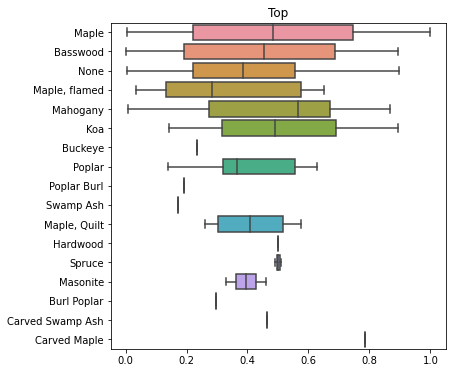

In [46]:
plot_wood('Top')

# Top
* Maple is the most common top used for Les Paul guitars and there are multiple variations of it, such as flamed or quilted.
* The flamed variety appears to be more popular than plain or quilted maple
* Some Les Pauls have no top but I'm surprised that some have a mahogany top. Perhaps these categories should be the same, but we won't know without examining particular guitar links.
* Again, many woods are only present in less than 10 models, so we can't say too much about them

                      count  mean  median
Neck                                     
Mahogany                410  0.47    0.47
Mahogany, Maple           3  0.51    0.51
Maple                    91  0.40    0.40
Maple, Walnut             3  0.29    0.23
Maple, Walnut, Maple      6  0.55    0.60
Nato                      6  0.35    0.36
Nyatoh                    9  0.30    0.24
Okume                     5  0.38    0.41
Rosewood                  1  0.69    0.69
Sapele                    1  0.41    0.41
Silver leaf Maple         1  0.43    0.43


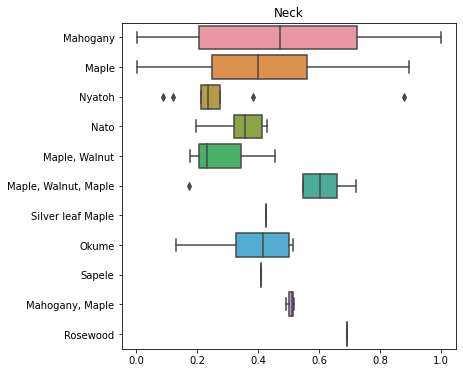

In [47]:
plot_wood('Neck')

# Neck
* Most Les Pauls have a mahogany neck to match their body, but maple can also be used. These two have similar popularity levels.
* Mixtures of maple and walnut are also used but there are very few of these in the dataset

                       count  mean  median
Fretboard                                 
Amaranth                  21  0.35    0.42
Blackwood                  6  0.33    0.30
Ebony                    123  0.49    0.52
Engineered Hard  Wood      2  0.31    0.31
Indian Laurel             26  0.24    0.22
Jatoba                    48  0.23    0.22
Laurel                    11  0.33    0.32
Maple                      1  0.40    0.40
Ovangkol                   5  0.50    0.62
Pao Ferro                 32  0.33    0.32
Pine Wood                  1  0.26    0.26
Purple Heart               2  0.42    0.42
Resonator Wood             9  0.24    0.16
Richlite                   6  0.67    0.69
Roseacer                  12  0.55    0.55
Rosewood                 222  0.54    0.61
Tigerstripe Ebony          3  0.59    0.54
Walnut                     7  0.41    0.50


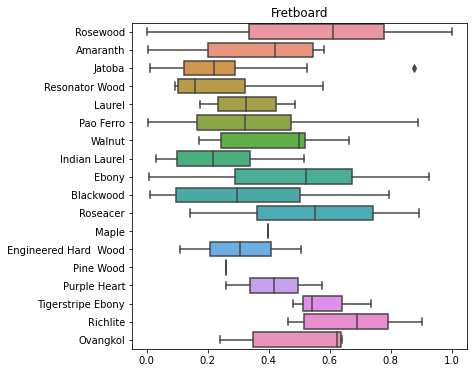

In [48]:
plot_wood('Fretboard')

# Fretboard
* There are many varieties of fretboard, but rosewood is the typical wood of choice. It accounts for almost half of the fretboards and isn't as popular as some of the cheaper alternatives.
* Jatoba, also called Brazilian cherry, is such an alternative. It is similar to rosewood in tone and appearance and appears to be present in higher ranked guitars. Given the moderate correlation of rank with price, this would be in agreement with our previous observation that cheaper guitars tend to rank more highly

# Which features of an electric guitar are most important in determining the price?<a id="features_price"></a>
[back to top](#intro)

To address this question, we could use any number of machine learning methods, but I think linear regression will prove quite useful in determining how different features drive up the cost of a Les Paul electric guitar, as we can look at the coefficients used in the model to determine feature importance. We'll also use mean squared error (MSE) and R-squared to evaluate performance on the test data.

In [68]:
# import sklearn stuff
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# reload dataframe from file
df = pd.read_csv('processed_lp_product_data.csv')
print(f"There are {df.shape[1]} columns we could use\n")
for col in df.columns:
    print(col)

There are 151 columns we could use

further_info_table
link
name
num_reviews
overall_rating
price
rank_in_group
rank_overall
sales_info
Frets
Scale
Colour_amber
Colour_black
Colour_black matt
Colour_black natural burst
Colour_black with graphics
Colour_black, white
Colour_blonde
Colour_blue
Colour_bourbon burst
Colour_brown
Colour_burgundy
Colour_burst
Colour_cherry
Colour_cherry burst
Colour_cherry burst flame
Colour_cherry sunburst
Colour_cognac burst flame
Colour_ebony
Colour_gold
Colour_green
Colour_grey
Colour_honey
Colour_honeyburst
Colour_iced tea
Colour_ivory
Colour_jade
Colour_lemon burst
Colour_lemon flame
Colour_mandarin
Colour_matte green
Colour_miscellaneous
Colour_natural
Colour_natural koa
Colour_ocean flame
Colour_paradise flame
Colour_purple
Colour_red
Colour_silver
Colour_silver burst
Colour_smokehouse burst
Colour_sunburst
Colour_tobacco
Colour_tobacco sunburst
Colour_trans cherry burst
Colour_vintage burst
Colour_vintage sunburst
Colour_walnut
Colour_white
Colour_wo

In [69]:
# select feature columns
X = df.drop(columns=['price', 'link', 'sales_info', 'overall_rating',
                     'further_info_table', 'name'])
y = df['price']

# make splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                   random_state=42)

# instantiate and train model
model = LinearRegression(normalize=True)
model.fit(X_train, y_train)

def evaluate_model(model):
    """
    make predictions and calculate MSE using the provided model
    
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    # get square root of mse values to determine mean
    # variability in price predictions
    train_error = round(train_mse ** 0.5)
    test_error = round(test_mse ** 0.5)
    print(f"MSE on train\t\t{train_mse}")
    print(f"MSE on test\t\t{test_mse}")
    print(f"Training price predictions were wrong by about €{train_error}")
    print(f"Test price predictions were wrong by about €{test_error}")
    
evaluate_model(model)

MSE on train		997034.0293333334
MSE on test		3.485587477130229e+34
Training price predictions were wrong by about €999
Test price predictions were wrong by about €186697281103133088


I was afraid this might happen. Given the large number of variables and relatively small number of observations, our model didn't perform well on the train data, and as a result performed far worse on the test dataset.

I will re-use some earlier code to create a dataset without the dummy variables, use one-hot encoding, and train on a tree-based model. The encoding should work best for a tree-based model as it shouldn't treat categorical variables with multiple options as ranked, which would be problematic for a linear regression model.

In [70]:
# readin raw data
df = pd.read_csv('raw_lp_product_data.csv')

# extract data from 'further_info_table'
extract_further_info(df)

# fill num_reviews with 0 if NaN
df['num_reviews'].fillna(0, inplace=True)

# encode ratings column as categorical variable
df['overall_rating'] = np.where(df['overall_rating'].isna(), 0, 1)

# format price column
df['price'] = df['price'].apply(fix_price)

# change scale and frets columns to integers
df['Scale'] = df['Scale'].str.replace(' mm', '').astype(float)
df['Frets'] = df['Frets'].astype(float)

# strip whitespace from string columns
df = strip_whitespace(df)

In [71]:
# import decision tree classifier
from sklearn.tree import DecisionTreeRegressor

# redefine X and y
X = df[['num_reviews', 'rank_in_group', 'Colour', 'Body', 'Top',
      'Neck', 'Fretboard', 'Scale', 'Pickups', 'Tremolo']]
# encode categorical variables
for col in ['Colour', 'Body', 'Top', 'Neck', 'Fretboard',
            'Scale', 'Pickups', 'Tremolo']:
    # Replace NaN values with string
    X[col] = X[col].fillna('nan_replace')
    unique_vals = X[col].unique().tolist()
    num_vals = list(range(len(unique_vals)))
    d = dict(zip(unique_vals, num_vals))
    X[col] = X[col].map(d)

y = df['price']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                   random_state=42)

# instantiate model
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

evaluate_model(model)

MSE on train		0.0
MSE on test		1654981.6445783132
Training price predictions were wrong by about €0
Test price predictions were wrong by about €1286


<ipython-input-71-308a2afd8e43>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna('nan_replace')
<ipython-input-71-308a2afd8e43>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].map(d)


We now get great performance on the training data, but we're over-fitting, resulting in poor performance on the test data. Let's try some hyperparameter tuning and cross-vaildation to improve the model

In [33]:
from sklearn.model_selection import GridSearchCV

model = DecisionTreeRegressor()

def tune_hyperparams(model):
    """
    Fit hyperparameters to a model using grid search and
    cross-validation to find and return the optimal
    combination of hyperparameters
    
    """
    # Hyper parameter intialization for tuning 
    parameters = {"max_depth" : [5, 7, 9, 11, 12],
               "min_samples_leaf" : [3, 5, 7, 9],
               "min_weight_fraction_leaf" : [0.1 ,0.2 ,0.3, 0.4, 0.5],
               "max_features" : ["auto", "log2", "sqrt", None],
               "max_leaf_nodes" : [None, 20, 40, 60, 80, 100]}


    tuning_model = GridSearchCV(model, param_grid=parameters,
                                scoring='neg_mean_squared_error', cv=5, verbose=2)
    tuning_model.fit(X_train, y_train)
    return tuning_model.best_params_

# get best parameters from grid search results
# this may take a few minutes
best_params = tune_hyperparams(model)
print(best_params)

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, total=   0.0s
[CV] max_d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.2 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.2, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.2 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.2, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.2 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.2, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.2 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=

KeyboardInterrupt: 

In [30]:
# fit model and evaluate
model = DecisionTreeRegressor(**best_params)
model.fit(X_train, y_train)

evaluate_model(model)

MSE on train		2349940.844331052
MSE on test		2401673.302543906


Now we get a greater amount of error on the training data, but it's comparable to that of the test data. More importantly, the test error is approximately 8 times less than that of an out-of-the-box decision tree classifier.

However, these MSE values translate to about a €1500 error on the price of a guitar. That's pretty bad considering the mean value of guitars is about €1000. Maybe it's time for an ensemble model.

In [34]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

evaluate_model(model)

MSE on train		513714.45702930755
MSE on test		1110207.2160096287
Training price predictions were wrong by about €717
Test price predictions were wrong by about €1054


An OOB ensemble tree is definitely much better, but let's try hyperparameter tuning and see if we can improve it!

In [ ]:
# instantiate model
model = GradientBoostingRegressor()

# hyperparameter tuning (about 6 minutes)
best_params = tune_hyperparams(model)

# instantiate model with best parameters
model = GradientBoostingRegressor(**best_params)
model.fit(X_train, y_train)

evaluate_model(model)

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, total=   0.1s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, total=   0.0s
[CV] max_d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2, total=   0.0s
[CV] max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2 
[CV]  max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=

Sadly, hyperparameter tuning actually made the results worse. So, with an OOB model, let's look at the feature importances and see which is best.

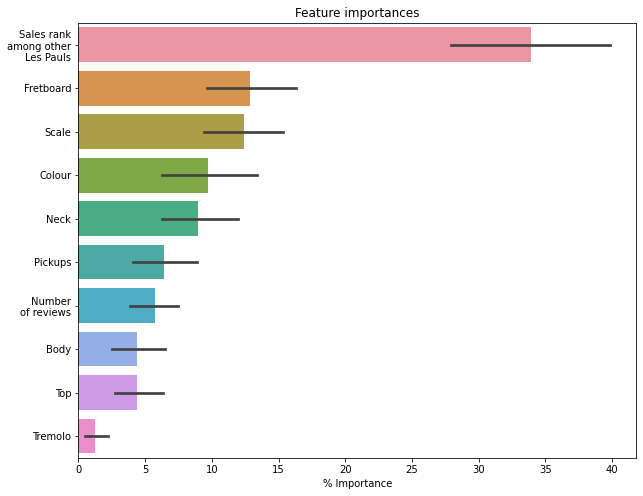

In [37]:
# fit raw model
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

# combine feature names and importances into a DataFrame
feature_names = X.columns.tolist()

# rename rank_in_group and num_reviews
for col, newname in zip(['rank_in_group', 'num_reviews'],
                        ['Sales rank\namong other\nLes Pauls', 'Number\nof reviews']):
    idx = feature_names.index(col)
    feature_names[idx] = newname

all_importances = [tree[0].feature_importances_ * 100 for tree in model.estimators_]
dfs = [pd.DataFrame(zip(feature_names, coefs), columns=['Features','% Importance']) for coefs in all_importances]
results = pd.concat(dfs)

# get order of features by mean
means = results.groupby('Features', as_index=False)['% Importance'].mean()
sorted_means = means.sort_values('% Importance', ascending=False)
order = sorted_means['Features'].tolist()

# plot feature importances
plt.figure(figsize=(10,8))
plt.title("Feature importances")
sns.barplot(y="Features", x="% Importance", data=results, orient='h',
           order=order)
plt.ylabel('')
plt.savefig('04_feature_importances.png')

# Feature importances
* Sales rank in the same group is a high predictor of price, which isn't surprising given their moderate correlation
* Scale and Fretboard wood are the next most important features, contributing an average of 25% feature importance between them
* Colour and Neck material each account for roughly 10% of the feature importance

For now, this is the best model we have, but more in-depth data processing and feature engineering could yield better results. Alternatively, we may leverage neural networks for predicting Les Paul guitar prices.

Keep an eye on this repository for further research into guitar price predictions!